In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

sys.path.append("../stylegan/")
from nn import StyleGANGenerator
from brats_dataset import BraTS20Dataset

#### Config

In [2]:
TRAINING_OUTPUT_DIR = "/exports/lkeb-hpc/csrao/git-personal/stylegan/stylegan/training_output"
DATA_ROOT = "/exports/lkeb-hpc/csrao/datasets/BraTS2020_train_kaggle"

#### Initialize stuff

In [3]:
# Load model
model_path = f"{TRAINING_OUTPUT_DIR}/checkpoints/iter_365000.pt"
state_dict = torch.load(model_path)
model = StyleGANGenerator(128, prog_growth=False).to('cuda')
model.load_state_dict(state_dict['net_g_state_dict'])

# Load and preprocess the query image
dataset = BraTS20Dataset(DATA_ROOT, prog_growth=False)
query_image = dataset[0]['image'].to('cuda')

## Inversion

  0%|          | 0/200 [00:00<?, ?it/s]

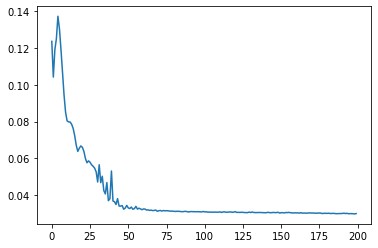

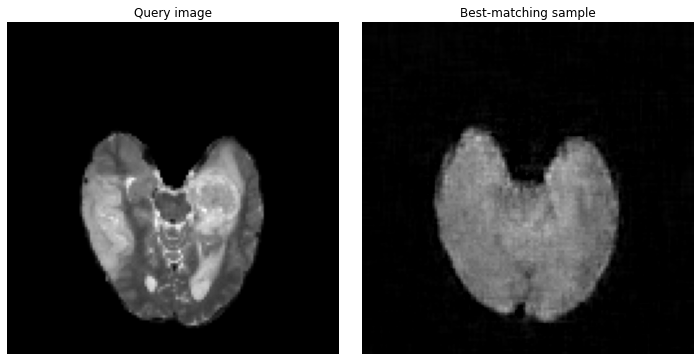

In [13]:
# Random init the latent
latent = torch.randn((1, 512), requires_grad=True, device='cuda')

# Optimizer for doing the inversion
optimizer = torch.optim.Adam([latent], lr=0.1)

# Optimization loop
loss_curve = []
for _ in tqdm(range(200)):
    optimizer.zero_grad()
    sample = model(latent)
    loss = torch.mean((sample - query_image) ** 2)
    loss.backward()
    optimizer.step()
    loss_curve.append(float(loss.detach().cpu()))
plt.plot(loss_curve); plt.show()

# Visualize closest matching sample from the model
with torch.no_grad():
    sample = model(latent)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(query_image.cpu().squeeze(), cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(sample.cpu().squeeze(), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title("Query image")
axs[1].set_title("Best-matching sample")
[ax.axis('off') for ax in axs.ravel()]
fig.tight_layout()
plt.show()